# `<Title>`

Authors:
- Carson Jan
- Ken Yang
- Xiaoheng Wang
- Yunle Xu

DSCI 100 003 <br>
Project Final Report <br>
Group 30

---
# Introduction
## Background infomation on the topic
The project focuses on data from a MineCraft research server set up by UBC Computer Science. The server records player actions, and the goal is to address practical challenges:

1. Player Recruitment: Identifying which types of players contribute the most data to target recruitment effectively.
2. Resource Allocation: Predicting player activity to manage server resources like hardware and licenses.

The main question is: “Which kinds of players are most likely to contribute a large amount of data?”

Using a Jupyter Notebook, the project will clean data, explore patterns, build predictive models, and document results for actionable insights.

## Posted question
We choose the first question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.


## Description of the dataset used
|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|

---
# Methods & Results
## Methods used
## Code

#### Libraries/ initialization

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Load data

In [2]:
players <- read_csv('data/players.csv')
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


#### Wrangle & Clean data

In [3]:
mapping_exp <- c("Beginner" = 1, "Amateur" = 2, "Regular" = 3,
                 "Pro" = 4, "Veteran" = 5)
mapping_gender <- c("Male" = 1, "Female" = 2, "Non-binary" = 3,
                 "Agender" = 4, "Two-Spirited" =5, "Prefer not to say"=6)

players_clean <- players |>
    filter(gender != 'Other') |> 
    #there is only 1 gender=Other dp, will cause error in scaling if not filtered
    mutate(experience2 = as.integer(mapping_exp[experience])) |>
    mutate(subscribe2 = as.integer(subscribe)) |>
    mutate(gender2=as.integer(mapping_gender[gender])) |>
    mutate(gender3=gender) |> mutate(value=1) |> #one hat encoding: this and next line
    pivot_wider(names_from=gender3, names_prefix='gender_', values_from=value, values_fill=0) |> 
    select(-hashedEmail, -name, -individualId, -organizationName) #rm data not important to Qs/NA
head(players_clean, 3)

# selects only fields needed for regression
players_reg <- players_clean |> select(played_hours, 'age':'gender_Two-Spirited', -gender2)
head(players_reg, 3)


experience,subscribe,played_hours,gender,age,experience2,subscribe2,gender2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited
<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Male,9,4,1,1,1,0,0,0,0,0
Veteran,TRUE,3.8,Male,17,5,1,1,1,0,0,0,0,0
Veteran,FALSE,0.0,Male,17,5,0,1,1,0,0,0,0,0


played_hours,age,experience2,subscribe2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.3,9,4,1,1,0,0,0,0,0
3.8,17,5,1,1,0,0,0,0,0
0.0,17,5,0,1,0,0,0,0,0


#### Summary of dataset
> exploratory data analysis related to the planned analysis 

#### Visualization of dataset 
> exploratory data analysis related to the planned analysis

In [ ]:
h <- players_clean |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
        scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 50, 100, 150, 200),
                    minor_breaks = NULL)
                    

a <- players_clean |>
    ggplot(aes(x=played_hours, y=age)) +
        geom_point(alpha=0.3) +
        scale_x_log10()


g <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=fct_reorder(gender, gender2))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

e <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=(fct_reorder(experience, experience2)))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

s <- players_clean |>
    ggplot(aes(x=played_hours, y=subscribe)) +
        geom_point(alpha=0.3) +
        scale_x_log10()

options(repr.plot.width=9)
h
grid.arrange(s, a, g, e, ncol=2)

#### Data analysis

Warning message:
“!  The following column has zero variance so scaling cannot be used:
  gender_Agender.
ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
  before normalizing.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


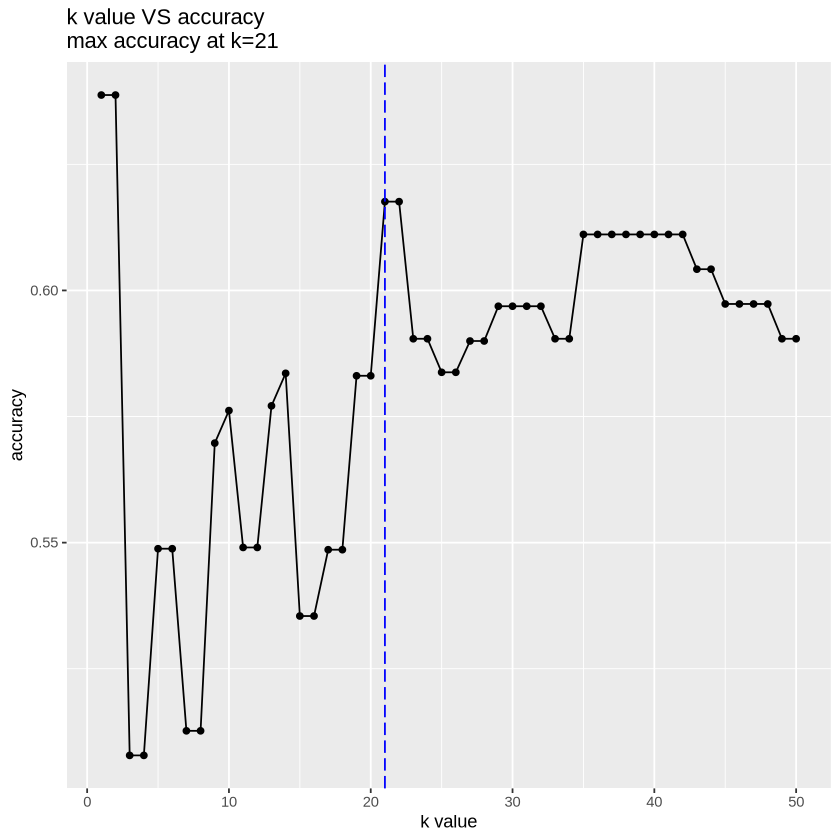

In [21]:
set.seed(2024)

#
players_class <- players_reg |> mutate(played = as.factor(ifelse(played_hours!=0, 1, 0)))
#
players_split <- initial_split(players_class, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

###
recipe_players <- recipe(played ~ .,
                         data=players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ks <- tibble(neighbors = seq(1,50,1))

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
      set_engine('kknn') |>
      set_mode('classification') 

players_vfold <- vfold_cv(players_training, v=5, strata=played_hours)

players_tune <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec_tune)|>
    tune_grid(resample=players_vfold, grid=ks) |>
    collect_metrics() |>
    filter(.metric == 'accuracy')


players_tune_plot <- players_tune |>
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x='k value', y='accuracy', title='k value VS accuracy\nmax accuracy at k=21') +
    geom_vline(xintercept = 21, color='blue', linetype = "longdash")

players_tune_plot

players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 21) |> 
      set_engine('kknn') |>
      set_mode('classification') 

players_fit <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec)|>
    fit(players_testing)

players_predictions <- predict(players_fit, players_testing) |>
    bind_cols(players_testing)

players_metrics <- metrics(players_predictions, truth=played, estimate=.pred_class) |>
    filter(.metric=='accuracy')
players_metrics 


###
# recipe_players <- recipe(played_hours ~ .,
#                          data=players_training) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors())

# ks <- tibble(neighbors = seq(1,100,1))

# players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
#       set_engine('kknn') |>
#       set_mode('regression') 

# players_vfold <- vfold_cv(players_training, v=10, strata=played_hours)

# players_tune <- workflow() |>
#     add_recipe(recipe_players) |>
#     add_model(players_spec_tune)|>
#     tune_grid(resample=players_vfold, grid=ks) |>
#     collect_metrics() |>
#     filter(.metric=='rmse')

# slice_min(players_tune, mean, n=1)

# players_tune_plot <- players_tune |>
#     ggplot(aes(x=neighbors, y=mean)) +
#     geom_point() +
#     geom_line() +
#     labs(x='k value', y='RMSE', title='k value VS RMSE\nminimum RMSE at k=76') +
#     geom_vline(xintercept = 76, color='blue', linetype = "longdash")

# players_tune_plot


##### Choice of k value
Choosing the k that yields the lowest RMSE, 
we choose k=76 for our model

In [20]:
set.seed(2024)

players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 76) |> 
      set_engine('kknn') |>
      set_mode('regression') 

players_fit <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec)|>
    fit(players_training)

players_summary <- players_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) |>
          metrics(truth = played_hours, estimate = .pred)
players_summary

# players_fit_plot <- players_fit_df |>
#     ggplot(aes(x = played_hours, fill = .pred_cluster)) +
#           geom_histogram(bins=100) +
#           scale_x_log10()+
#           labs(title = "Cluster Highlighting",
#                x = "X Axis Label",
#                y = "Y Axis Label") +
#           theme_minimal()
# players_fit_plot

#####
# players_fit_plot <- players_fit_df |>
#     pivot_longer(cols=-.pred_cluster, names_to='category', values_to='value') |> 
#     mutate(color = ifelse(.pred_cluster == "Cluster_5"|.pred_cluster == "Cluster_2", "orange", "grey")) |>
#     ggplot(aes(x = value, fill = color)) +
#           geom_histogram(bins=100) +
#           # geom_density(alpha=0.4, color='white') +
#           scale_fill_identity() +
#           # scale_color_manual(values = c("TRUE" = "orange", "FALSE" = "grey")) +
#           facet_grid(rows=vars(category), scales='free') +
#           scale_x_log10()+
#           # labs(title = "Cluster Highlighting",
#           #      x = "X Axis Label",
#           #      y = "Y Axis Label") +
#           theme_minimal()
# players_fit_plot

# # 3    4.9019885 -0.33080125  -0.1117853  0.5367297  0.1973320
# # players_max_t <- players_fit_df |>
# #     filter(.pred_cluster == 'Cluster_3')
# # players_max_t

.pred,played_hours,age,experience2,subscribe2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9.868421,0.7,21,2,1,0,1,0,0,0,0
8.861842,1.6,23,5,1,0,1,0,0,0,0
5.576316,0.0,22,2,0,1,0,0,0,0,0
9.873684,48.4,17,2,1,0,1,0,0,0,0
5.975000,1.0,17,1,1,1,0,0,0,0,0
4.948684,0.0,23,5,0,1,0,0,0,0,0
5.611842,0.0,17,5,1,1,0,0,0,0,0
5.944737,0.0,17,2,1,1,0,0,0,0,0
7.977632,0.1,17,5,1,0,0,1,0,0,0


#### Visualization
> note: all figures should have a figure number and a legend

---
# Discussion
## Summarization
## Is it what we expected to found?
## What impact could such findings have
## What future questions chould this lead to?

---
# References
> *note to group members: Use APA 7, please*

---
End of report <br>
Finalized and approved by all group member on `<date>`
> *note to group members: run report through grammar check, please*


To be uploaded by `<member>` by `<date>`